In [13]:
%matplotlib inline
from tensorscaling import scale, capacity, unit_tensor, random_tensor, marginal, random_unitary, random_orthogonal
import numpy as np
import scipy as scipy
from scipy import optimize
import cvxpy as cp
import matplotlib.pyplot as plt
from numpy import matrix
from sympy import *
import itertools

# Tensor scaling

Scale 3x3x3 unit tensor to certain non-uniform marginals:

In [ ]:
shape = [3, 3, 3]
targets = [(.5, .25, .25), (.4, .3, .3), (.7, .2, .1)]

res = scale(unit_tensor(3, 3), targets, eps=1e-4)
res

We can also access the scaling matrices and the final scaled state:

In [ ]:
print(res.gs[0], "\n")
print(res.gs[1], "\n")
print(res.gs[2])

Let's now check that the W tensor *cannot* be scaled to uniform marginals:

In [22]:
shape = [2, 2, 2, 2]
W = np.zeros(shape)
W[1, 0, 0, 0] = W[0, 1, 0, 0] = W[0, 0, 1, 0] = W[0, 0, 0, 1] = .5
targets = [(.5, .5)] * 4
print(targets)

scale(W, targets, eps=1e-4, max_iterations=1000)

[(0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5)]


Result(success=False, iterations=1000, max_dist=0.5934653559719874, ...)

To see more clearly what is going on, we can set the `verbose` flag:

In [ ]:
res = scale(W, targets, eps=1e-4, max_iterations=10, verbose=True)

We see that at each point in the algorithm, one of the marginals has Frobenius distance $\approx 0.59$ to being uniform. Indeed, we know that the entanglement polytope of the W tensor does not include the point corresponding to uniform marginals -- see [here](https://www.entanglement-polytopes.org/four_qubits) for an interactive visualization!

# Tuples of matrices and tensors

We can just as well only prescribe the desired spectra for subsystems.
Note that prescribing two out of three marginals amounts to *operator scaling*.

In [ ]:
shape = [3, 3, 3]
targets = [(.4, .3, .3), (.7, .2, .1)]

res = scale(unit_tensor(3, 3), targets, eps=1e-6)
res

Indeed, the last two marginals are as prescribed, while the first marginal is arbitrary.

In [ ]:
print(marginal(res.psi, 0).round(5), "\n")
print(marginal(res.psi, 1).round(5), "\n")
print(marginal(res.psi, 2).round(5))

# Duality


**The scaling way:** The below computes $\frac{1}{t}\inf_{\det L = \det R = 1} \langle L \otimes R,  e^{tC} \rangle $ for inputs $C = uni (spec) uni^\dagger$, dimension $n$, and weight $t$.

In [4]:
def scalingot(spec,uni,n,weight):
    #marginals p and q are just normalized identities
    targets = [tuple((n**(-1))*np.ones(n)), tuple((n**(-1))*np.ones(n))]

    expcost = uni.copy()
    #make the unitary a list of nxn matrices  
    expcost=expcost.reshape([n**2,n,n])


    expspec = np.exp(weight*spec)
    #multiply the i^{th} eigenvector by e^(weight*spec[i])
    for i in range(0,n**2):
        expcost[i]*=expspec[i]
    cap = capacity(expcost, targets, eps=1e-4, max_iterations=400,randomize=False, verbose=False)
    
    return cap/weight



**The SDP way:** Compute the sdp $\max C \cdot \rho$ subject to $  E_{ij} \otimes I_n \cdot \rho = P_{ij}$ and $ I_n \otimes E_{ij} \cdot \rho = Q_{ij}$ and, of course $\rho \succeq 0$. 

In [3]:

def sdpot(spec, uni, n):
    #compute the cost matrix C = uni*spec*uni^T
    C = uni.dot(np.diag(spec).dot(np.conj(uni).T))
    #currently the marginals are just the normalized identities
    p = np.eye(n,n)/n
    q = np.eye(n,n)/n


    X = cp.Variable((n**2,n**2), symmetric=True)
    constraintos = [X >> 0]

#add the partial trace constraints

    for i in range(n):
        for j in range(i+1):
            a = np.kron(np.kron(np.eye(1,n,i), np.eye(n,1,-j)), np.eye(n,n))        #c.reshape([n**2,n**2])
            a = (a + a.T)/2
        
            constraintos += [cp.trace(a @ X) == p[i,j]]
        
        
        
    for i in range(n):
        for j in range(i+1):
            a = np.kron(np.eye(n,n), np.kron(np.eye(1,n,i), np.eye(n,1,-j)))        #c.reshape([n**2,n**2])
            a = (a + a.T)/2
        
            constraintos += [cp.trace(a @ X) == q[i,j]]


    prob1 = cp.Problem(cp.Maximize(cp.trace(C @ X)),
                  constraintos)

    prob1.solve()
    
    return prob1.value

    


**Sanity check:** when the cost C is diagonal these algorithms should match 

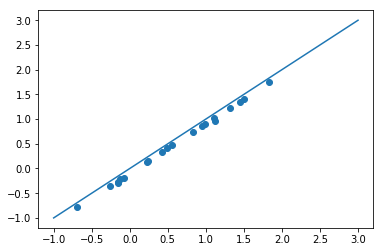

In [5]:
n = 2
scal = []
sdp = []

for i in range(20):
    #choose random spectrum for cost matrix
    spec = np.random.randn(n**2)
    #C will be uni*spec*uni^T, for now we make C diagonal 
    uni = np.eye(n**2)
    #compute the mincost using both algorithms
    sc = scalingot(spec,uni,n,4)
    sd = sdpot(spec,uni,n)
    #put them in a list
    scal.append(sc)
    sdp.append(sd)
#scatter plot it
x = np.arange(-1,4)
plt.plot(x,x)
plt.scatter(scal,sdp)




    

**In general:** we don't know what will happen, but it doesn't look like they are the same. 
EDIT: this supports Jason's calculation that the scaling is always bigger.

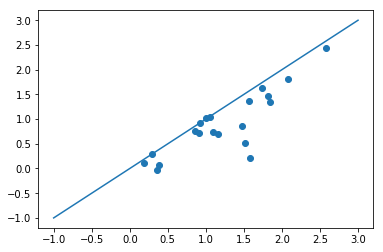

In [6]:
n = 2
scal = []
sdp = []
spec = np.random.randn(n**2)



for i in range(20):
    spec = np.random.randn(n**2)
    #same except this time we use random unitary so that C is quite random
    uni = random_orthogonal(n**2)
    sc = scalingot(spec,uni,n,40)
    sd = sdpot(spec,uni,n)
    scal.append(sc)
    sdp.append(sd)
x = np.arange(-1,4)
plt.plot(x,x)
plt.scatter(scal,sdp)


Based on that crazy formula I conjectured for the scaling limit, I conjectured that the scaling limit would depend only on the spectrum and not the unitary (provided the unitary is random). This looks true!

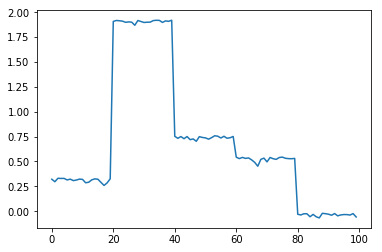

In [52]:
n = 2
scal = []
sdp = []

for j in range(5):
    spec = np.random.randn(n**2)
    for i in range(20):
    
        uni = random_orthogonal(n**2)
        sc = scalingot(spec,uni,n,30)
        scal.append(sc)

plt.plot(scal)

The same does not appear to be true for the sdp.

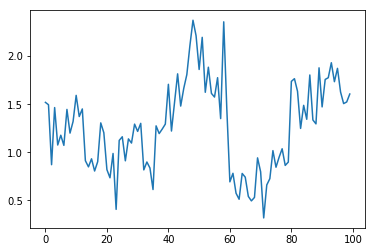

In [50]:
n = 2
scal = []
sdp = []

for j in range(5):
    spec = np.random.randn(n**2)
    for i in range(20):
    
        uni = random_orthogonal(n**2)
        sd = sdpot(spec,uni,n)
        sdp.append(sd)

plt.plot(sdp)

 # Ok next, check if this is the same thing as that optimization problem
 
 1. I believe that what we want to compare against is $$\inf_{U} \max_{\mu(P) = 0} \sum_{\omega} P_\omega \max \{ c_i: (\pi(U) \rho_i)_\omega > 0\}$$
 2. So the first thing we have to do is try to maximize something over unitaries. However, this is not obviously an easy task. Maybe what's better is to try to test if a given function $\omega \to \max \{i: (\pi(U) \rho_i)_\omega > 0\}$ is admissible. Note: has nothing to do with cost. Patterns that are admissible for random $\rho_i$ might actually be pretty easy to understand. 

**Testing if a function is admissible:** I have a feeling some algebraic geometers or representation theorists have a nice answer to this, but I can't find it.

**Symbolic scratch**

In [14]:
#test sympy:
x, y, z = symbols('x y z')
solve(Eq(x*y, 0.2), [x,y])

solve([x*y - z, y - z], [x,y,z])

[(1, z, z), (x, 0, 0)]

In [27]:
X = MatrixSymbol('X',2,2)

In [35]:
Y = matrix(Identity(2))
Y[0,1]=X[0,1]

Y*matrix(X)
#next question: can use the entries of this kind of thing as equations for the solver?

matrix([[X[0, 0] + X[0, 1]*X[1, 0], X[0, 1]*X[1, 1] + X[0, 1]],
        [X[1, 0], X[1, 1]]], dtype=object)

**Pattern admissibility testing**

Want to test if pattern is admissible. Pattern is array with numbers from 1 to n^2. Define pattern $\omega \mapsto i$ to be admissible if there exists $N$ unipotent such that $(N \cdot v_j)_\omega = 0$ for $j \geq i$. If $v$ is actually random, I hope that's the same as if there is a symbolic solution (I should probably actually try to understand that...) but first, let's just try with $v_j$ random. By the way it doesn't seem to matter if the $v_j$ are orthonormal in this case; we could have started with a gram matrix and then orthogonalized it. Also this suggests the solution should actually be the SAME for every random basis!!!


The below currently tests if a pattern is admissible for $n = 2$.

In [125]:
n = 2

#define the unipotents
def patterntest4(pat,n):
    x,y = symbols('x y')

    N1 = matrix(Identity(n))
    N1[1,0]=x
#X = Matrix(MatrixSymbol('X',n,n))
#for i in range(n):
#    for j in range(i):
#        N1[i,j] = X[i,j]

    N2 = matrix(Identity(n))
    N2[1,0]=y
#Y = Matrix(MatrixSymbol('Y',n,n))
#for i in range(n):
#    for j in range(i):
#        N2[i,j] = Y[i,j]
        
#next, need to act on v_j by it.
    N = np.kron(N1,N2)
#print(N)
#get the vectors; gotta be more careful whether it's the row or what.
    uni = random_orthogonal(n**2)
#uni = Matrix(MatrixSymbol('Z',n**2,n**2))

    acted = N*uni
#print(acted)
#so the columns are N\cdot v_i. So then pattern tells us how many of the final entries
#should be zero in row omega.
#np.reshape(uni, [n**2,n**2])

#this should take in a list of vectors 
    

    system = []

    for i in range(n**2):
        for j in range(pat[i],n**2):
            system.append(acted[i,j])
    #print(len(system))
#x= symbol('X[1,0]'y = symbol('Y[1,0]')
    #print(solve(system, [x,y]))
    if len(solve(system, [x,y]))==0:
        return 0
    else:
        return 1



Test it out.

In [127]:
patterntest4((4,4,4,3),2)

1

**Find all admissible patterns for $n = 2$.** This has some chance of producing a bogus pattern, but it should be low.

In [133]:
n = 2
x = itertools.product(range(1,n**2+1),range(1,n**2+1),range(1,n**2+1), range(1,n**2+1) )
#x = itertools.product(x, range(n**2))
#x = itertools.product(x,range(n**2))

y = 0
patterns = []
for pat in x:
    #print(tuple(pat))
    if patterntest4(pat,n)==1:
        patterns.append(pat)
        
print(patterns)


        
        
    

    


[(4, 3, 3, 4), (4, 3, 4, 4), (4, 4, 3, 4), (4, 4, 4, 2), (4, 4, 4, 3)]


Now, the formula predicts that we take the minimum diagonal sdp cost over these patterns.

In [18]:

patterns = [(4, 3, 3, 4), (4, 3, 4, 4), (4, 4, 3, 4), (4, 4, 4, 2), (4, 4, 4, 3)]
def formula2(spec, n):
    spec.sort()
    sdpvals = []
    #patterns needs to be the above thing.
    for pat in patterns:
        entries = np.zeros(n**2)
        for i in range(n**2):
            entries[i] = spec[pat[i]-1]
            sdpvals.append(sdpot(entries,np.eye(n**2),n))
    print(np.argmin(sdpvals))
    return 2*min(sdpvals)

In [19]:
n=2
scal = []
sdp = []
for run in range(20):
    
    spec = np.random.randn(n**2)
    uni = random_orthogonal(n**2)
    scal.append(scalingot(spec,uni,n, 20))
    spec.sort()
    sdpvals = []
    sdp.append(formula2(spec,n))
plt.scatter(scal,sdp)
fig = plt.figure()
ax = plt.axes()
x = np.linspace(-1, .0001, 2)
ax.plot(x, x);



NameError: name 'argmin' is not defined

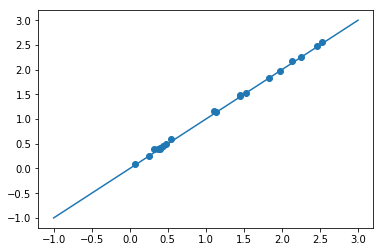

In [17]:
x = np.arange(-1,4)
plt.plot(x,x)
plt.scatter(scal,sdp)

# Conjecture
I want to see if $$cap(\rho) = - \inf_{\tau:\mu(\tau) = 0} \sum_{i = 1}^{n^2} \tau_i \ln \tau_i - \sum_{i = 1}^{n^2} (\tau_i - \tau_{i + 1}) pm_k( u^\dagger \rho u).$$
I can imagine optimizing this by 
1. directly optimizing over it parameterized this way
2. Parameterizing by projections 
3. Optimizing over a general linear matrix and taking the QR part out.


**Attempt 1: Optimizing directly**: First I want to check if I can just optimize directly. Perhaps I actually need a formula for the gradients, etc. So I need the constraints  
1. $ \sum_{j} u_{ij} u_{ik} = \delta_{ik}$.
2. $\tau_1 \geq \dots \geq \tau_{n^2} \geq 0$.
3. $\langle I \otimes E_{ij}, \sum \tau_i u_i u_i^\dagger \rangle = \delta_{ij}/n$ and same for $E_{ij} \otimes I$.

In [153]:
#test scipy optimize.
def f(x,z):
    #can use np arrays.
    x = np.array(x)
    return z*x[0]**2 + x[0]*(x[1]**2 - 1)
def g(x):
    x = np.array(x)
    return x[0][0] + x[1][1]


cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2 * x[1] + 2})
cons2 = ({'type': 'ineq', 'fun': lambda x:  x[0][0]*x[1][1] -  x[0][1]* x[1][0]})

In [154]:
z = 1
scipy.optimize.minimize(lambda x: f(x,1), [1,1], constraints=cons)

     fun: -0.2499998845211134
     jac: array([-0.00033974,  0.00041609])
 message: 'Optimization terminated successfully.'
    nfev: 29
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([4.99830034e-01, 4.16221235e-04])

In [34]:
scipy.optimize.minimize(g, [[1,1],[1,-1]], constraints=cons2)

IndexError: invalid index to scalar variable.

In [44]:
#mat should be n \times n array.
#computes the log of kth principal minor
def lpm(mat, k):
    mat = mat[:k,:k]
    return np.log(scipy.linalg.det(mat))
    

In [66]:
mat = np.array([[1,0],[0,.5]])
lpm(mat,1)

0.0

In [182]:
#computes the objective function in the markdown cell above
def keyl(x, rho, N):
    tau, uni = separate(x, N)
    #rho = np.array(rho)
    #uni= np.array(uni)
    tau.sort()
    tau = list(tau)
    tau.append(0.0)
    tau = np.array(tau)
    uni = np.array(uni)
    #print(np.shape(uni))
    uni = uni.reshape([N,N])
    #print(np.shape(uni))
    
    mat = (np.conj(uni).T).dot(rho.dot(uni))
    ent = 0
    for i in range(N):
        ent+= tau[i]*np.log(tau[i])- (tau[i] + tau[i + 1])*lpm(mat,i+1)
    return ent
    
    
    
    

In [179]:
def taucons(x, N):
    tau, uni = separate(x, N)
    tau.sort()
    return tau[-1]

In [189]:
def tracecons(x,N):
    tau, uni = separate(x, N)
    return sum(tau)-1



In [186]:
def unicons(x,i,j,N):
    tau, uni = separate(x, N)
    uni= np.array(uni)
    uni = uni.reshape([N,N])
    return uni.dot(uni.T)[i,j] - np.eye(N)[i,j]

In [98]:
def partial(mat,i,j,n):
    #requires that mat is N = n^2 by n^2
    return np.trace(np.dot(np.kron(np.kron(np.eye(1,n,i), np.eye(n,1,-j)), np.eye(n,n)),mat.T)) 

In [130]:
def partialcons(uni, tau, i, j, n):
    mat = uni.dot(rho.dot(uni.T))
    return partial(mat,i,j,n)- np.eye(n)[i,j]/n

In [100]:
def separate(x,N):
    tau = x[:N]
    uni = x[N:]
    return tau, uni

**Try with just unitary constraint;** should get 0.

In [195]:
#initialize:
n= 2
N = n**2
#set initial values
tau0 = np.ones(N)/N
uni0 = np.eye(N)/N

#turn it into one string
x0 = list(tau0)
x0.extend(list(uni0.reshape(N**2)))
#print(x0)

#initialize rho randomly
rho = np.random.randn(N,N)
rho = rho.dot(rho.T)
rho = rho/np.trace(rho)
#print(rho)


#need constraint functions that depend on entire string x
cons = []
cons.append({'type': 'ineq', 'fun': lambda x: taucons(x,N)})
cons.append({'type': 'eq', 'fun': lambda x: tracecons(x,N)})



for i in range(N):
    for j in range(N):
        cons.append({'type': 'eq', 'fun': lambda x: unicons(x,i,j,N)})


#keyl(x0,rho,N)


**Ok, looks like this fails. Upon some googling, could have to do with continuity.**

In [216]:
scipy.optimize.minimize(lambda x: keyl(x,rho,N), x0,constraints=cons, method = 'BFGS')



/usr/local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


      fun: nan
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [

**Attempt 2: parameterize by $\Delta \tau_i$**

In [208]:
#computes the objective function in the markdown cell above
def deltakeyl(x, rho, N):
    delta, uni = separate(x, N)
    #rho = np.array(rho)
    #uni= np.array(uni)
    delta = np.array(delta)
    uni = np.array(uni)
    #print(np.shape(uni))
    uni = uni.reshape([N,N])
    #print(np.shape(uni))
    
    mat = (np.conj(uni).T).dot(rho.dot(uni))
    ent = 0
    tau = 0
    for i in range(N):
        tau+=delta[i]
        ent+= tau*np.log(tau)- delta[i]*lpm(mat,i+1)
    return ent
    
    
    
    

In [199]:
def deltacons(x, i, N):
    delta, uni = separate(x, N)
    return delta[i]

In [200]:
def deltatracecons(x,N):
    delta, uni = separate(x, N)
    s=0
    for i in range(len(delta)):
        s+=(i + 1)*delta[i]
    return s-1



In [212]:
#initialize:
n= 2
N = n**2
#set initial values
delta0 = np.zeros(N)
delta0[-1] = 1/N
print(delta0)
uni0 = np.eye(N)/N

#turn it into one string
x0 = list(tau0)
x0.extend(list(uni0.reshape(N**2)))
#print(x0)

#initialize rho randomly
rho = np.random.randn(N,N)
rho = rho.dot(rho.T)
rho = rho/np.trace(rho)
#print(rho)


#need constraint functions that depend on entire string x
cons = []
cons.append({'type': 'eq', 'fun': lambda x: deltatracecons(x,N)})

for i in range(N):
    cons.append({'type': 'ineq', 'fun': lambda x: deltacons(x,i,N)})




for i in range(N):
    for j in range(i):
        cons.append({'type': 'eq', 'fun': lambda x: unicons(x,i,j,N)})


#keyl(x0,rho,N)


[0.   0.   0.   0.25]


In [219]:
scipy.optimize.minimize(lambda x: deltakeyl(x,rho,N), x0,constraints=cons, method ='SLSQP')
#still doing it.


     fun: 10.892585334174402
     jac: array([ 6.15909171e+00,  1.03264091e+01,  1.54538453e+01,  2.16309950e+01,
       -7.99999988e+00,  0.00000000e+00, -1.19209290e-07, -1.19209290e-07,
       -2.37120867e-01, -5.99999988e+00,  0.00000000e+00,  0.00000000e+00,
       -1.07427633e+00,  9.25311565e-01, -4.00000000e+00,  0.00000000e+00,
        4.71324492e+00,  1.83095980e+00, -1.50353229e+00, -2.00000000e+00])
 message: 'Singular matrix C in LSQ subproblem'
    nfev: 22
     nit: 1
    njev: 1
  status: 6
 success: False
       x: array([0.25, 0.25, 0.25, 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ,
       0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.25])

In [163]:
#scratch
tau = [.7,.3]
uni1 = np.array([[0,1],[1,0]])
x = tau.copy()
x.extend(uni3)
uni2 = np.kron(uni1, np.eye(2))
rho1 = np.array([[1,0],[0,.5]])
print(keyl(tau, uni1, rho1))
print(unicons(uni1,0,0,2))
print(partial(uni2,0,1,2))
separate(x,2)
uni3.reshape([2,2])

TypeError: only integer scalar arrays can be converted to a scalar index

In [173]:
uni3 = np.array([1,2,3,4])
uni3.reshape([2,2])
print(uni3)

[1 2 3 4]


In [215]:
x = np.array([ 6.15909171e+00,  1.03264091e+01,  1.54538453e+01,  2.16309950e+01,
       -7.99999988e+00,  0.00000000e+00, -1.19209290e-07, -1.19209290e-07,
       -2.37120867e-01, -5.99999988e+00,  0.00000000e+00,  0.00000000e+00,
       -1.07427633e+00,  9.25311565e-01, -4.00000000e+00,  0.00000000e+00,
        4.71324492e+00,  1.83095980e+00, -1.50353229e+00, -2.00000000e+00])
scipy.linalg.det(x)

ValueError: expected square matrix